In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/CDV/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/CDV


In [6]:
from tools.misc_tools import create_CDV_data, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder

In [7]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [8]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [9]:
tf.test.gpu_device_name()

''

# CDV System

In [10]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # simutlation paramaters
    params_mat = np.array([
        [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5],
        [0.99, -0.801*0.99, 0.1, 1.25, 0.2, 0.5]
    ])

    init_state = [-1]*6

    t0 = 0.0
    T = 1500.0
    delta_t = 0.01

    return_params_arr = False
    normalize_flag = False

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')

    # saving sim data
    sim_data = {
        'params_mat':params_mat,
        'init_state':init_state,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'normalize_flag':normalize_flag
    }
    with open(dir_name_ae+dir_sep+'sim_data_params.txt', 'w') as f:
        f.write(str(sim_data))

else:
    # simutlation paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_005'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

In [11]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

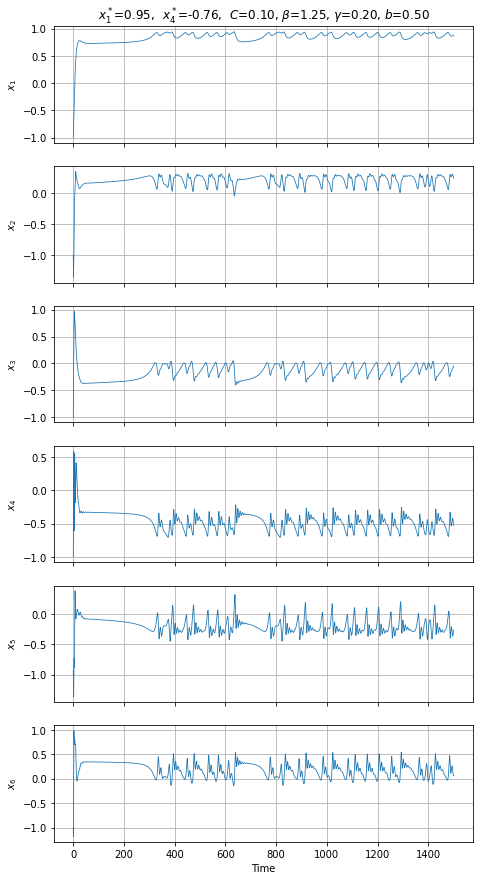

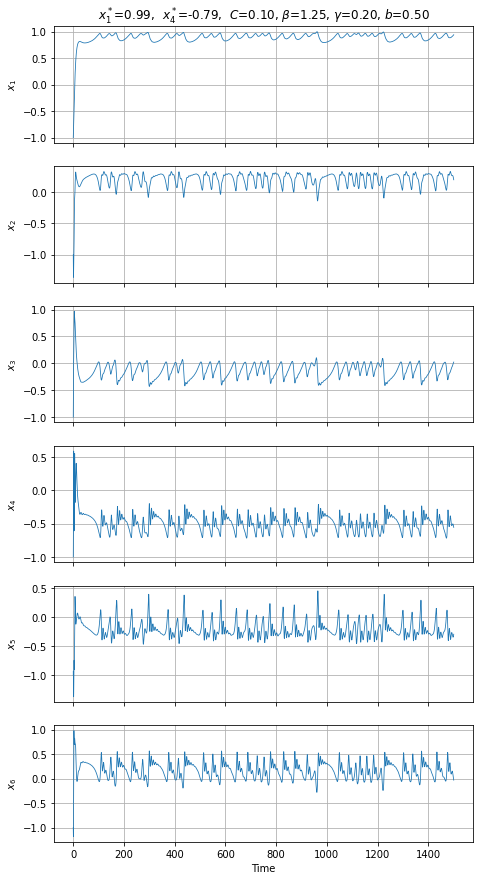

In [12]:
n = len(boundary_idx_arr)
# '''
num_cols = 1
num_rows = 6

factor = 1
# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

prev_idx = 0
for i in range(len(boundary_idx_arr)):
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(factor*7.5*num_cols, factor*2.5*num_rows))
    ax_ylabels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
    input_time = np.arange(0, N+1)*delta_t
    for j in range(6):
        ax[j].plot(input_time, all_data[i*(N+1):(i+1)*(N+1), j], linewidth=0.8)#, label='_nolegend_')
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    ax[0].set_title(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
        all_data[i*(N+1), 6],
        all_data[i*(N+1), 7],
        all_data[i*(N+1), 8],
        all_data[i*(N+1), 9],
        all_data[i*(N+1), 10],
        all_data[i*(N+1), 11]
    ))
    ax[-1].set_xlabel('Time')
    plt.show()
    print('')
# '''

# Autoencoder

In [13]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 40  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [14]:
# setting up data
idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1-test_split)*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
testing_data = all_data[idx[boundary:], :]

In [15]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    ae_net = Autoencoder(
        data_dim=12,
        enc_layers=[32,24,16,12,8,4,2],
        dec_layers=[2,4,8,12,16,24,32],
        latent_space_dim=2,
        lambda_reg=lambda_reg,
        reg_name='L2',
        enc_layer_act_func='elu',
        enc_final_layer_act_func='tanh',
        dec_layer_act_func='elu',
        dec_final_layer_act_func='linear',
        load_file=None)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    ae_net = Autoencoder(data_dim=12, load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
    ae_net.load_weights_from_file(wt_file)

In [16]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [17]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
            validation_split=val_split/train_split,
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
3692/3692 [==============================] - 18s 4ms/step - loss: 0.0058 - val_loss: 0.0022
Epoch 2/2000
3692/3692 [==============================] - 15s 4ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 3/2000
3692/3692 [==============================] - 14s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/2000
3692/3692 [==============================] - 17s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/2000
3686/3692 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 1m 17.1s

Epoch 5: val_loss improved from inf to 0.00136, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/CDV/saved_ae/ae_008/checkpoints/checkpoint
 - saving loss histories at /content/drive/MyDrive/Colab Notebooks/Thesi

In [18]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ae_net.evaluate(
        testing_data, testing_data,
    )

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

938/938 [==============================] - 2s 2ms/step - loss: 0.0011


In [19]:
lr_change

[0, 181, 237, 278]

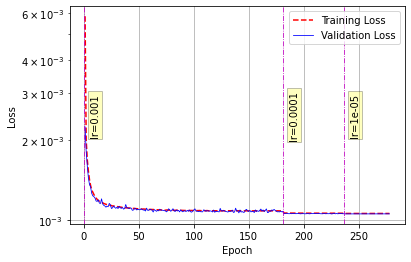

In [20]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [21]:
reconstructed_data = ae_net.predict(all_data)

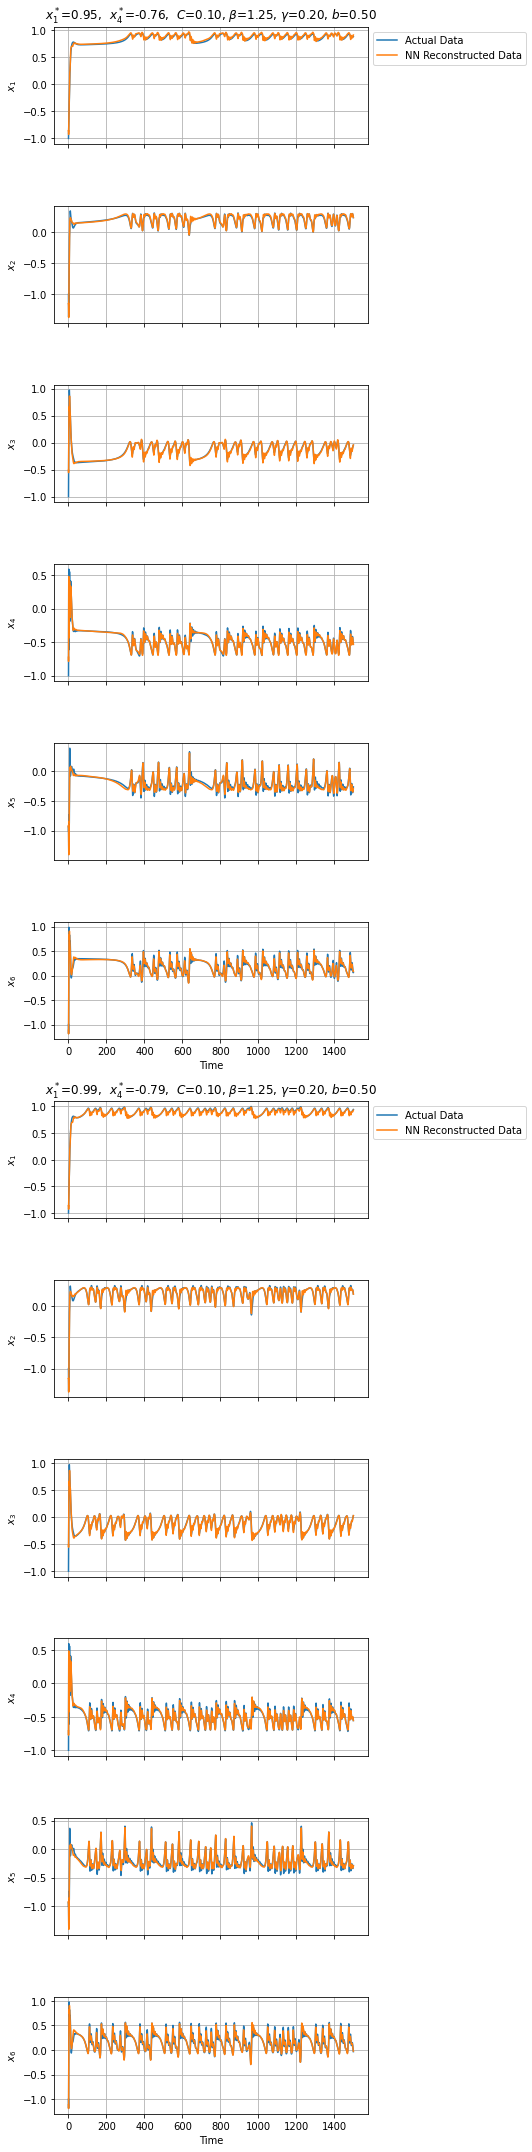

In [22]:
fig = plot_reconstructed_data_cdv(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    delta_t=delta_t,
    save_figs=False)

In [23]:
plot_reconstructed_data_cdv(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    delta_t=delta_t,
    save_figs=True)

In [24]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

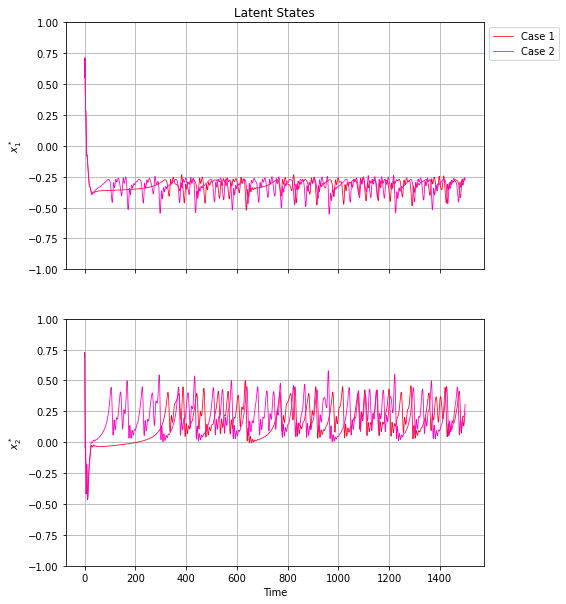

In [25]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    all_data,
    delta_t,
    params_mat,
    # xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10,
    legend_bbox_to_anchor=[1,1],
    save_config_path=dir_name_ae + '{ds}plots'.format(ds=dir_sep)
)

plt.savefig(dir_name_ae + '{ds}plots{ds}latent_space.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')

In [26]:
# ae_net.summary()

# LSTM